In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


=> Using device: cuda
Totally 500 samples in val set.
Starting Checking image&label pair val list...
Checking image&label pair val list done!


/content/drive/MyDrive/computer_vision/CV_1/codes_and_models/pspnet.py:257: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path), stric

=> Loading checkpoint from: /content/drive/MyDrive/computer_vision/CV_1/codes_and_models/train_epoch_200_CPU.pth


<ipython-input-20-4c87024ec250>:268: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(CHECKPOINT, map_location=device))


=> Starting evaluation...
Processing batch 1/63...
Processing batch 2/63...
Processing batch 3/63...
Processing batch 4/63...
Processing batch 5/63...
Processing batch 6/63...
Processing batch 7/63...
Processing batch 8/63...
Processing batch 9/63...
Processing batch 10/63...
Processing batch 11/63...
Processing batch 12/63...
Processing batch 13/63...
Processing batch 14/63...
Processing batch 15/63...
Processing batch 16/63...
Processing batch 17/63...
Processing batch 18/63...
Processing batch 19/63...
Processing batch 20/63...
Processing batch 21/63...
Processing batch 22/63...
Processing batch 23/63...
Processing batch 24/63...
Processing batch 25/63...
Processing batch 26/63...
Processing batch 27/63...
Processing batch 28/63...
Processing batch 29/63...
Processing batch 30/63...
Processing batch 31/63...
Processing batch 32/63...
Processing batch 33/63...
Processing batch 34/63...
Processing batch 35/63...
Processing batch 36/63...
Processing batch 37/63...
Processing batch 38/6

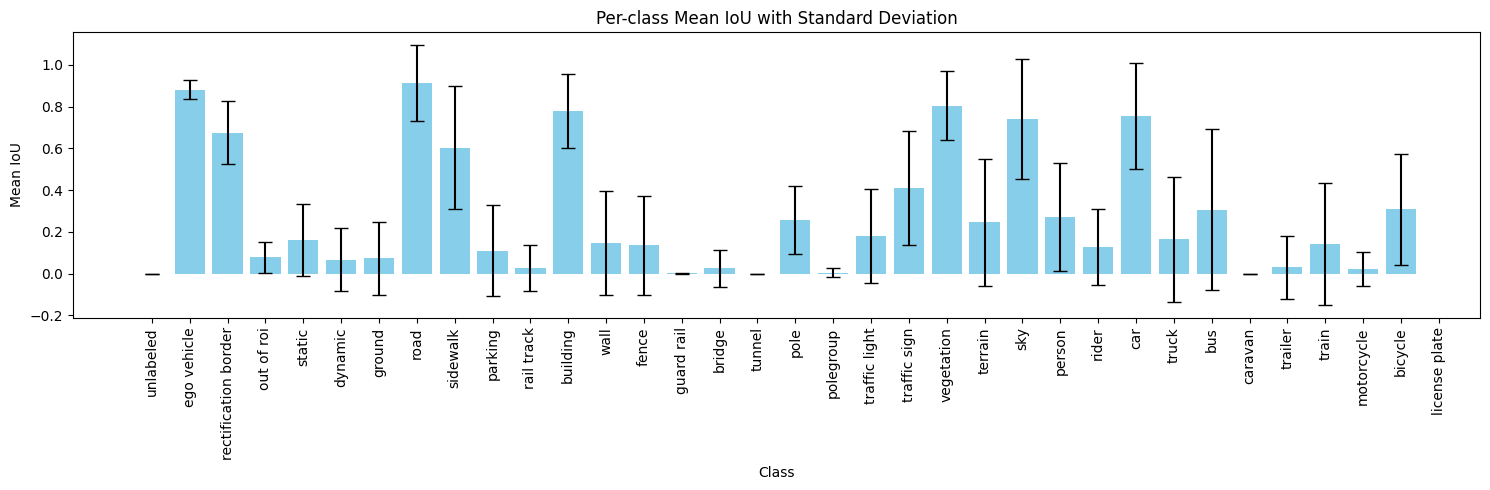

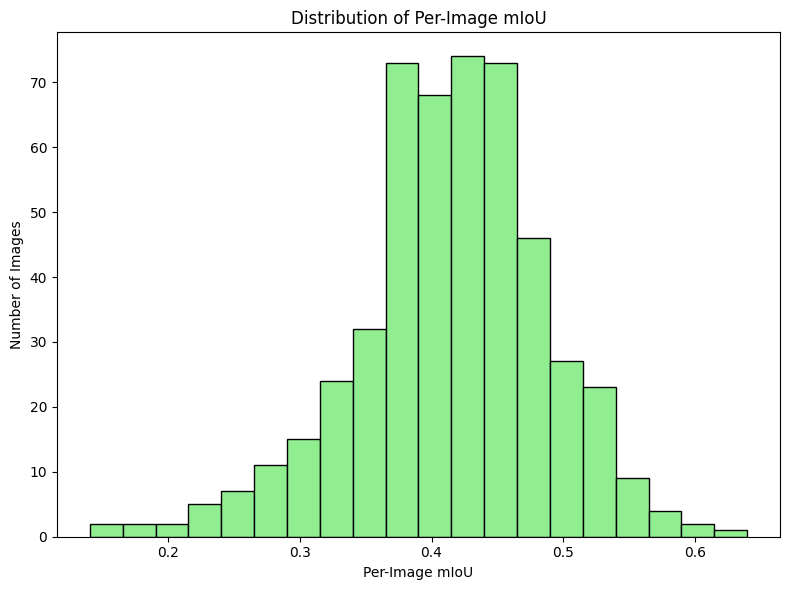

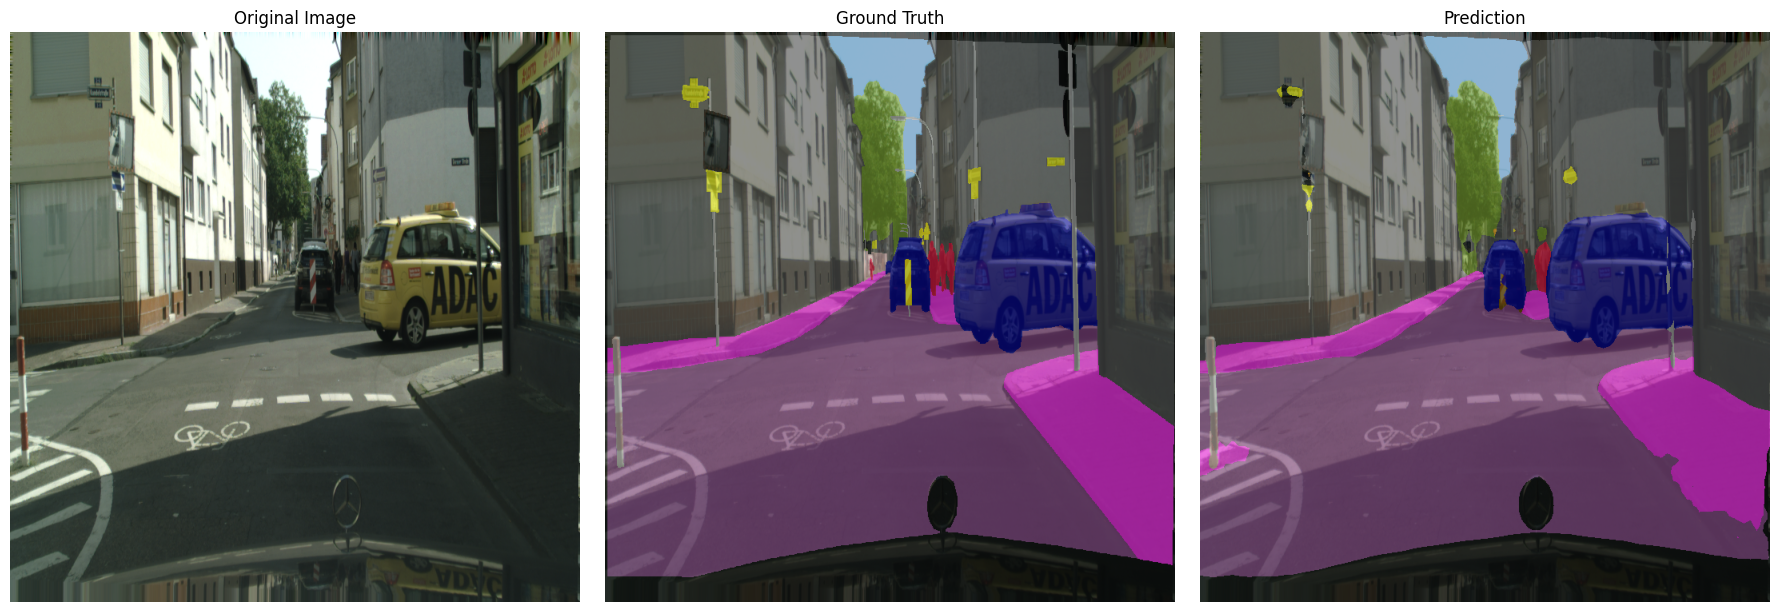

Saved sample visualization to sample_segmentation_0.png


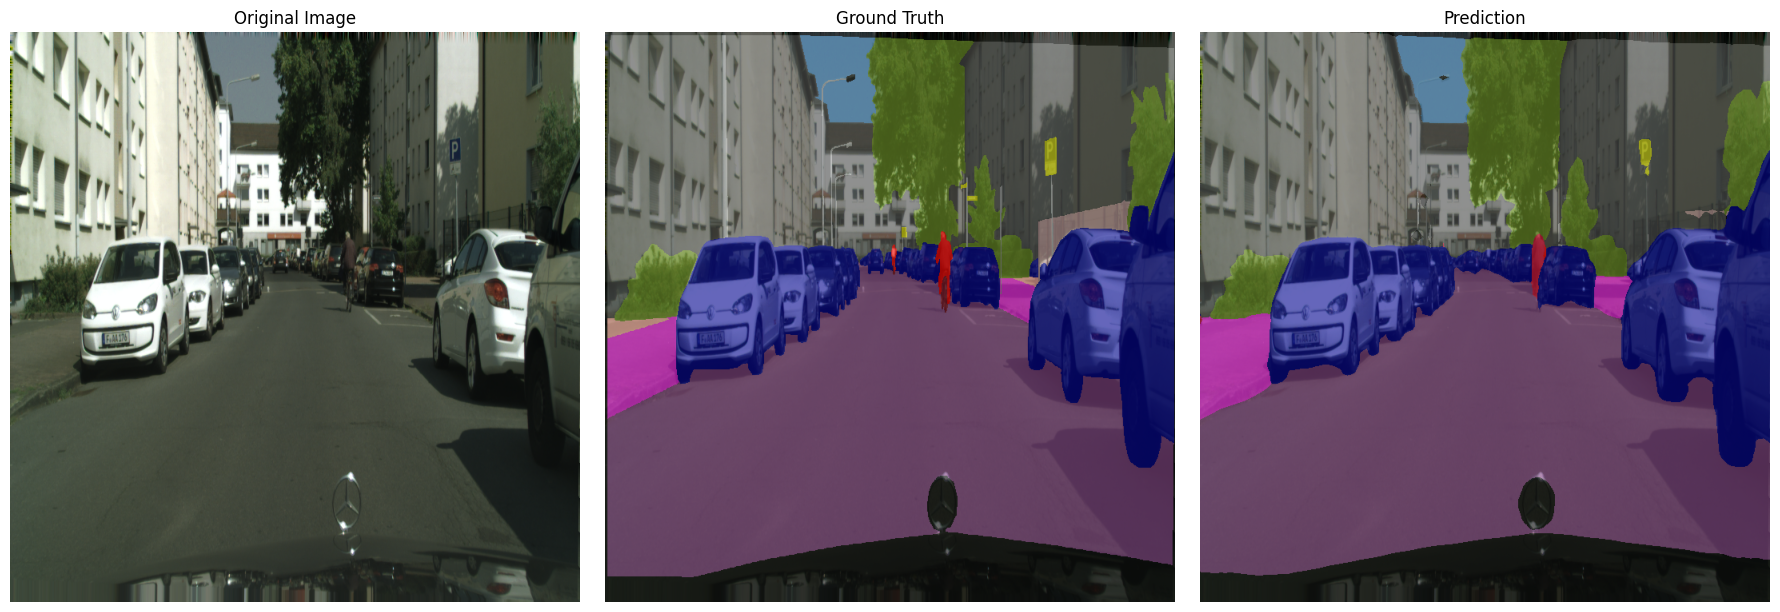

Saved sample visualization to sample_segmentation_1.png


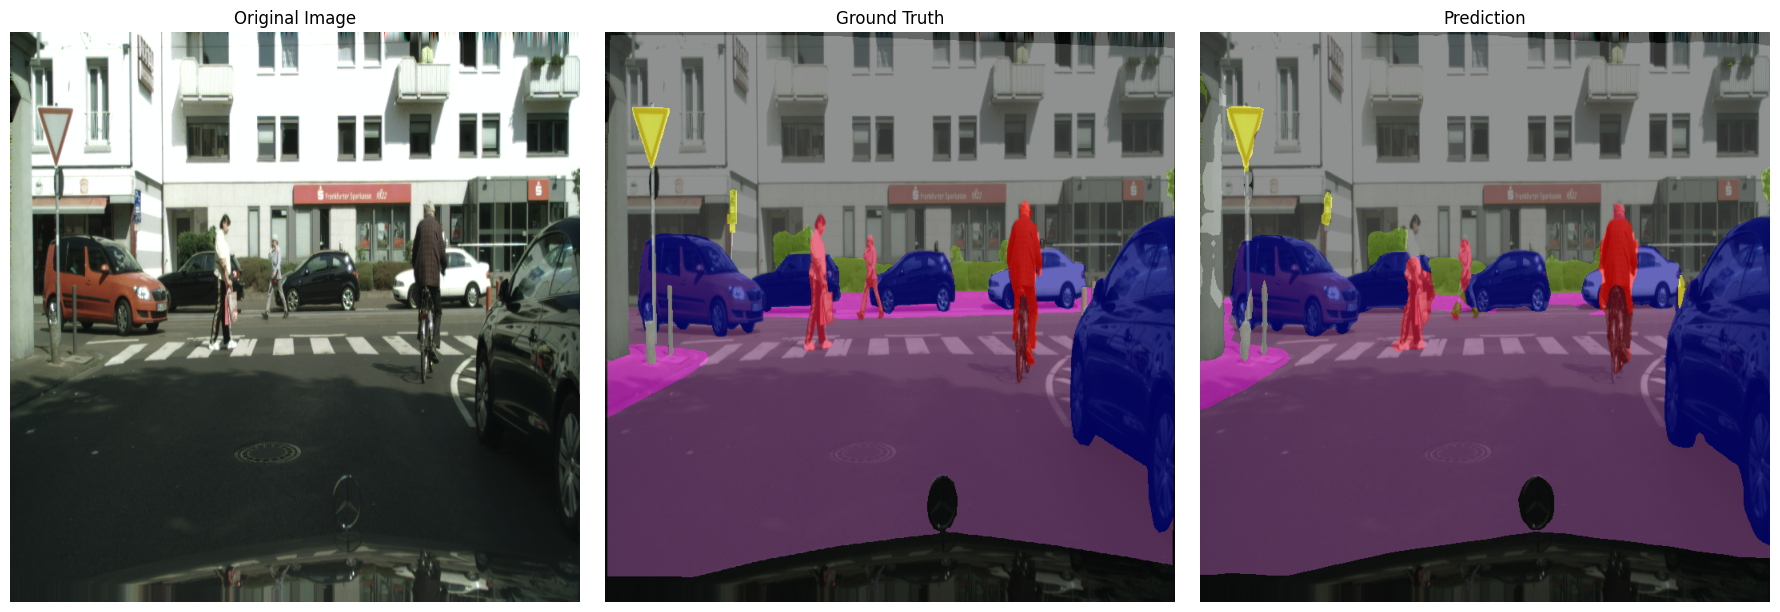

Saved sample visualization to sample_segmentation_2.png


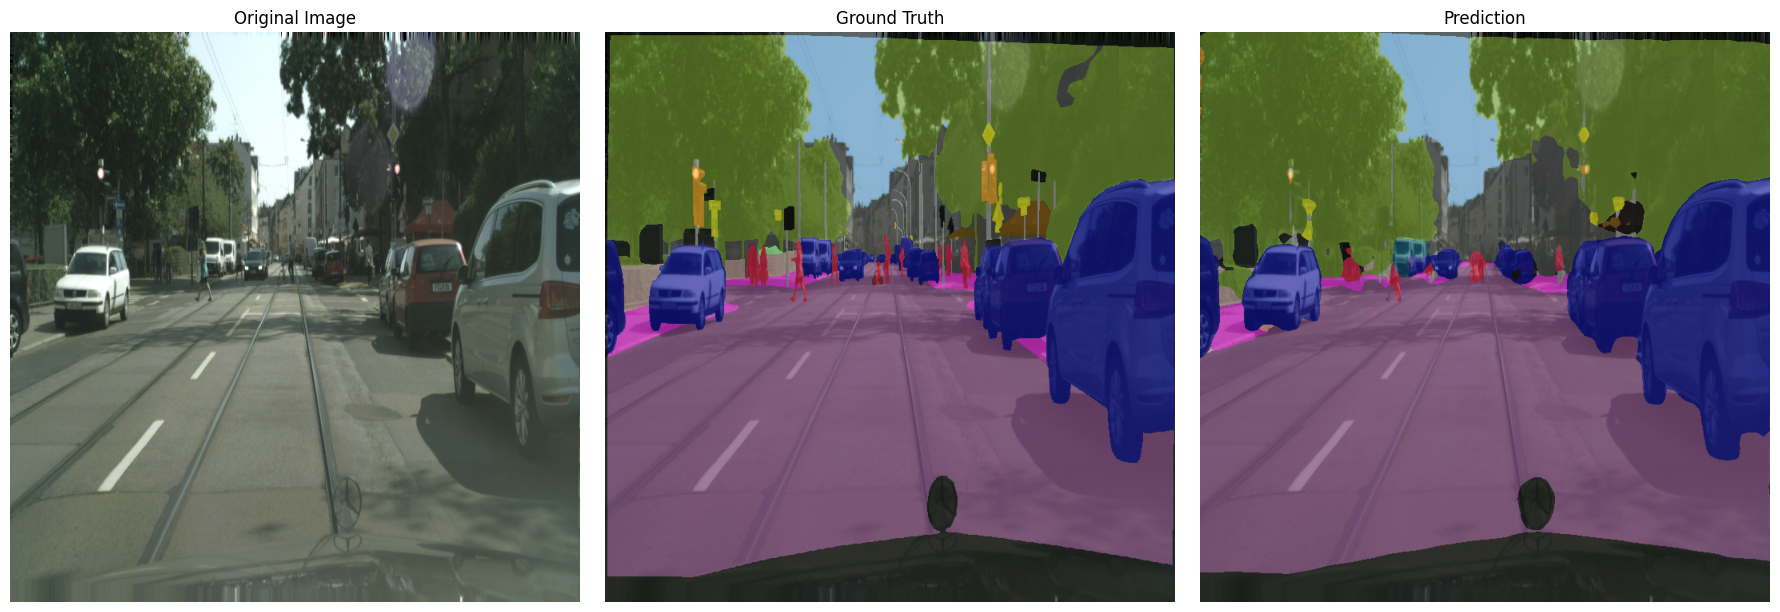

Saved sample visualization to sample_segmentation_3.png


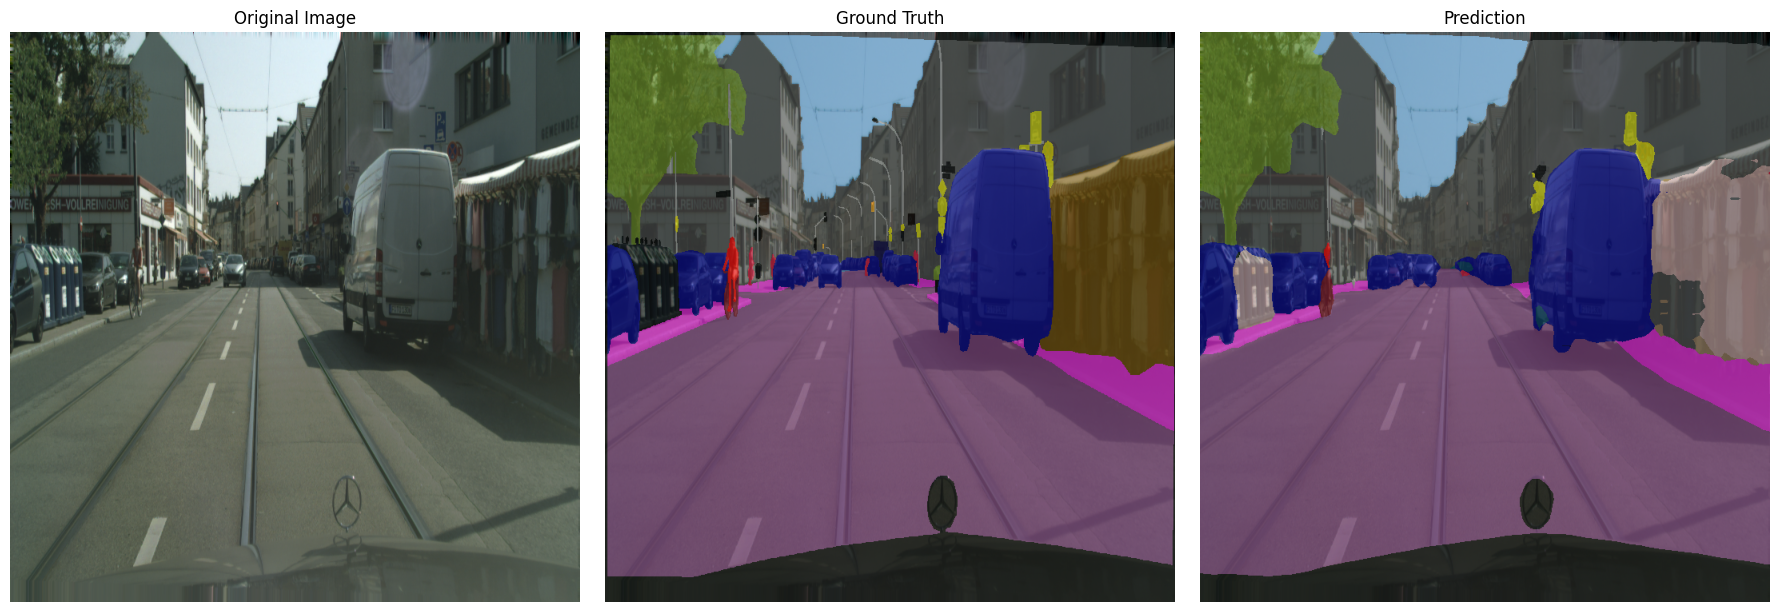

Saved sample visualization to sample_segmentation_4.png


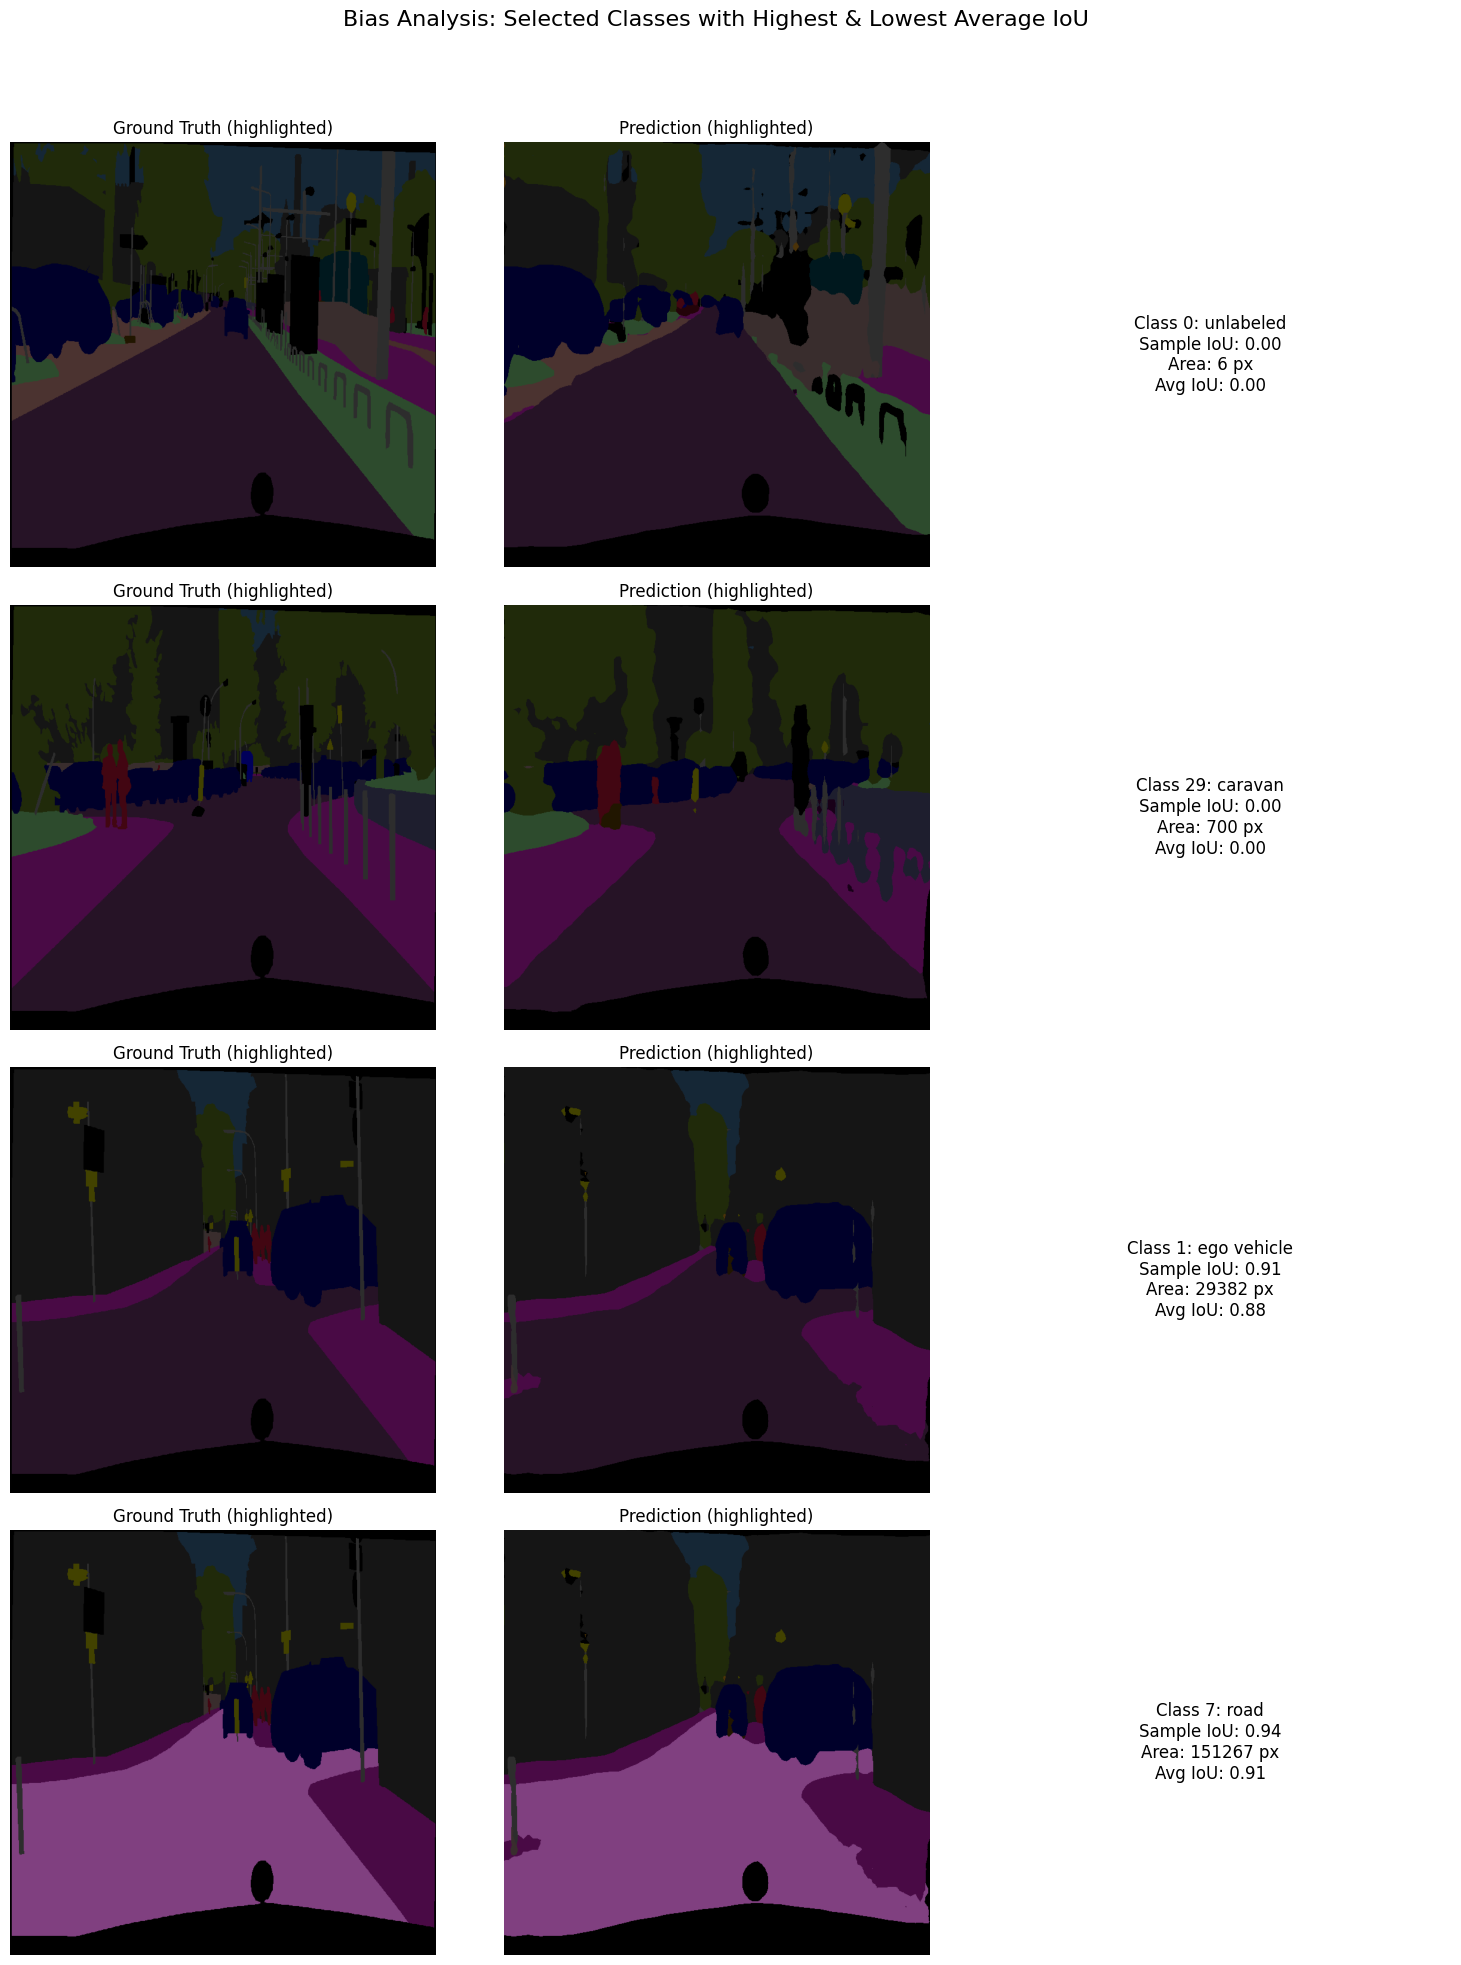

Saved bias analysis visualization to class_bias_analysis.png


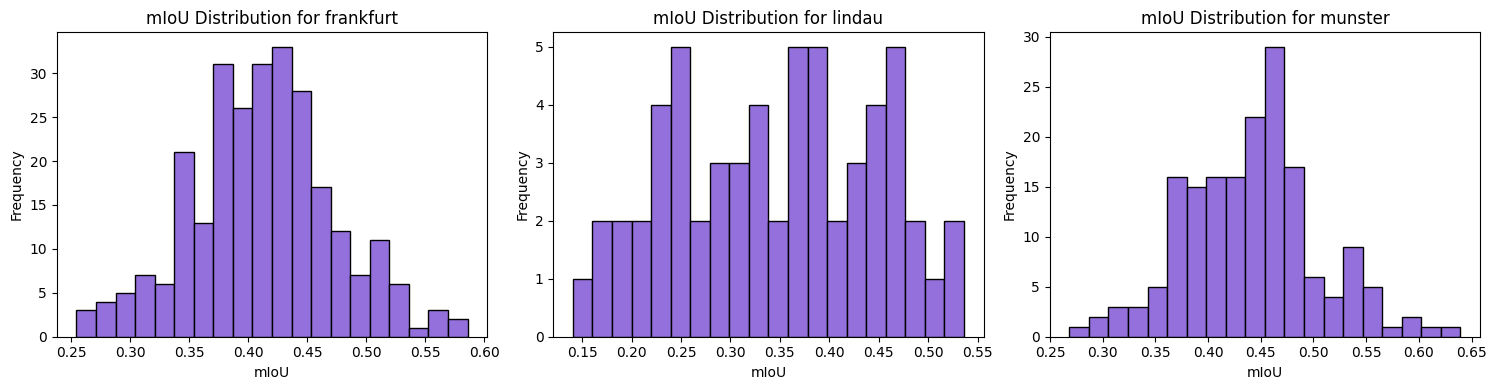

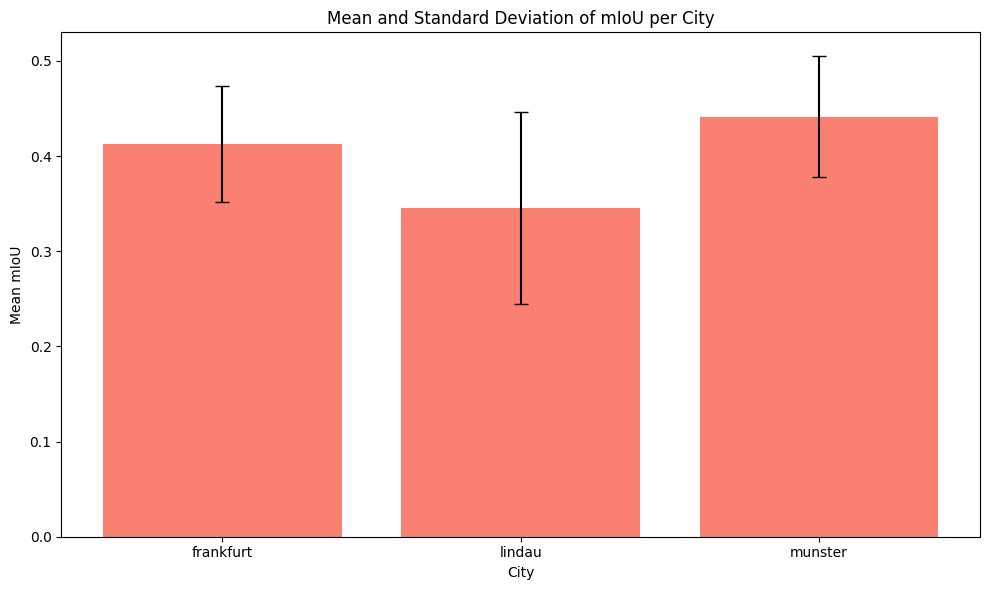

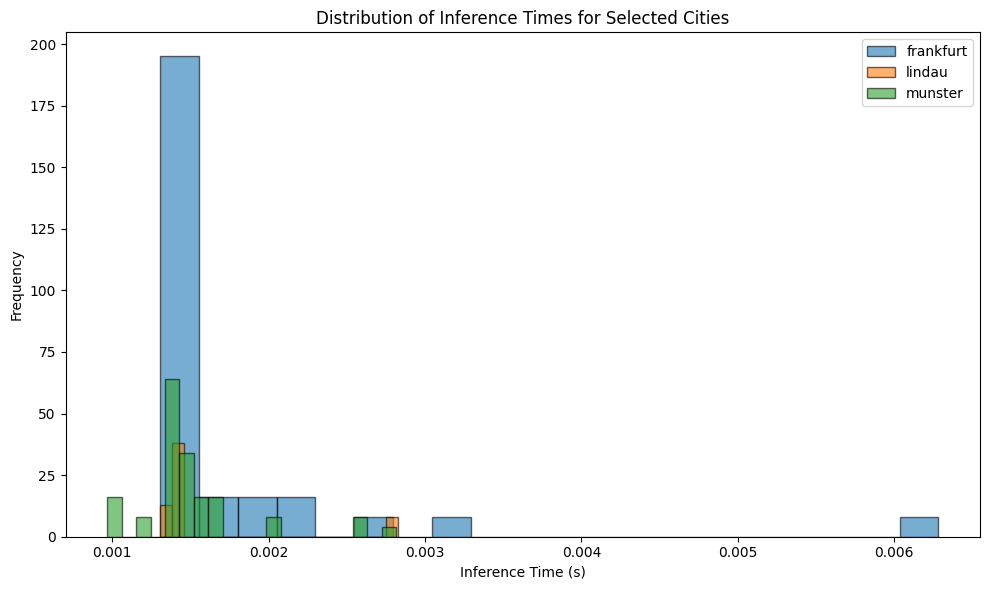

In [ ]:
import sys
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
import time
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix
from torch.amp import autocast  # Updated import

# Add project folder to path
sys.path.append('/content/drive/MyDrive/computer_vision/CV_1')
from codes_and_models.pspnet import PSPNet
from codes_and_models.cityscapes_dataset import Cityscapes

#############################################
#              User Settings                #
#############################################
DATA_ROOT   = '/content/drive/MyDrive/computer_vision/CV_1/cityscapes_dataset/'
DATA_LIST   = '/content/drive/MyDrive/computer_vision/CV_1/cityscapes_dataset/list/cityscapes/fine_val.txt'
CHECKPOINT  = '/content/drive/MyDrive/computer_vision/CV_1/codes_and_models/train_epoch_200_CPU.pth'
COLORS_PATH = '/content/drive/MyDrive/computer_vision/CV_1/codes_and_models/cityscapes_colors.txt'
NAMES_PATH  = '/content/drive/MyDrive/computer_vision/CV_1/codes_and_models/cityscapes_names.txt'

BATCH_SIZE  = 8
USE_AMP     = False      # Set True if you want to use automatic mixed precision
NUM_SAMPLES = 5          # Number of sample images for overall visualization

#############################################
#            Helper Functions               #
#############################################
def compute_mIoU(conf_matrix):
    """
    Given a confusion matrix for a single image, compute per-class IoU.
    """
    intersection = np.diag(conf_matrix)
    union = conf_matrix.sum(axis=1) + conf_matrix.sum(axis=0) - intersection
    iou = np.array([
        intersection[i] / union[i] if union[i] > 0 else np.nan
        for i in range(len(intersection))
    ])
    return iou

def load_colormap(colors_path, names_path):
    """
    Load the colormap and class names from text files.
    """
    colormap = {}
    with open(colors_path, "r") as f:
        lines = f.readlines()
        for i, line in enumerate(lines):
            parts = line.strip().split()
            if len(parts) >= 3:
                colormap[i] = tuple(map(int, parts[:3]))

    class_names = {}
    with open(names_path, "r") as f:
        lines = f.readlines()
        for i, line in enumerate(lines):
            class_names[i] = line.strip()

    return colormap, class_names

def decode_segmap(label_mask, colormap):
    """
    Decode a segmentation mask (H x W with class ids) into an RGB image.
    """
    r = np.zeros_like(label_mask, dtype=np.uint8)
    g = np.zeros_like(label_mask, dtype=np.uint8)
    b = np.zeros_like(label_mask, dtype=np.uint8)

    for cls in np.unique(label_mask):
        if cls in colormap:
            r[label_mask == cls] = colormap[cls][0]
            g[label_mask == cls] = colormap[cls][1]
            b[label_mask == cls] = colormap[cls][2]
    rgb = np.stack([r, g, b], axis=2)
    return rgb

def denormalize_image(img, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)):
    """
    Revert the normalization of an image.
    Assumes the image is a float numpy array in H x W x C format.
    """
    mean = np.array(mean)
    std = np.array(std)
    img = img * std + mean
    return img

def plot_per_class_iou(avg_iou, var_iou, class_names, save_path="per_class_iou.png"):
    """
    Plot a bar chart for per-class IoU with error bars representing the standard deviation.
    """
    classes = list(avg_iou.keys())
    means = [avg_iou[cls] for cls in classes]
    stds  = [np.sqrt(var_iou[cls]) if not np.isnan(var_iou[cls]) else 0 for cls in classes]

    plt.figure(figsize=(15, 5))
    plt.bar(range(len(classes)), means, yerr=stds, capsize=5, color='skyblue')
    plt.xticks(range(len(classes)), [class_names[cls] for cls in classes], rotation=90)
    plt.xlabel("Class")
    plt.ylabel("Mean IoU")
    plt.title("Per-class Mean IoU with Standard Deviation")
    plt.tight_layout()
    plt.savefig(save_path)
    plt.show()

def plot_per_image_miou(per_image_miou, save_path="per_image_miou_histogram.png"):
    """
    Plot a histogram showing the distribution of per-image mIoU values.
    """
    plt.figure(figsize=(8, 6))
    plt.hist(per_image_miou, bins=20, color="lightgreen", edgecolor="black")
    plt.xlabel("Per-Image mIoU")
    plt.ylabel("Number of Images")
    plt.title("Distribution of Per-Image mIoU")
    plt.tight_layout()
    plt.savefig(save_path)
    plt.show()

def visualize_sample(image, gt, pred, colormap, alpha=0.6, save_path=None):
    """
    Visualize one sample's segmentation: original image, ground truth overlay, and prediction overlay.
    """
    gt_rgb = decode_segmap(gt, colormap)
    pred_rgb = decode_segmap(pred, colormap)

    plt.figure(figsize=(18, 6))

    plt.subplot(1, 3, 1)
    plt.imshow(image)
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(image)
    plt.imshow(gt_rgb, alpha=alpha)
    plt.title("Ground Truth")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(image)
    plt.imshow(pred_rgb, alpha=alpha)
    plt.title("Prediction")
    plt.axis("off")

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path)
    plt.show()

def highlight_class_segmentation(segmentation, class_id, colormap):
    """
    Highlight the selected class in the segmentation mask.
    Returns an RGB image where only pixels of the given class are highlighted
    and other regions are darkened.
    """
    seg_rgb = decode_segmap(segmentation, colormap)
    mask = (segmentation == class_id)
    highlighted = seg_rgb.copy().astype(np.float32) / 255.0
    highlighted[~mask] *= 0.3
    highlighted = np.clip(highlighted, 0, 1)
    return highlighted

def plot_city_miou_histograms(city_miou, save_path="city_miou_histograms.png"):
    """
    For each city, plot a histogram of per-image mIoU values.
    """
    num_cities = len(city_miou)
    ncols = 3
    nrows = int(np.ceil(num_cities / ncols))
    plt.figure(figsize=(5 * ncols, 4 * nrows))
    for i, city in enumerate(sorted(city_miou.keys())):
        plt.subplot(nrows, ncols, i+1)
        plt.hist(city_miou[city], bins=20, color='mediumpurple', edgecolor='black')
        plt.xlabel("mIoU")
        plt.ylabel("Frequency")
        plt.title(f"mIoU Distribution for {city}")
    plt.tight_layout()
    plt.savefig(save_path)
    plt.show()

def plot_city_mean_std_miou(city_miou, save_path="city_mean_std_miou.png"):
    """
    Plot a bar chart of the mean mIoU with error bars (standard deviation) for each city.
    """
    cities = sorted(city_miou.keys())
    means = [np.mean(city_miou[city]) for city in cities]
    stds = [np.std(city_miou[city]) for city in cities]
    plt.figure(figsize=(10, 6))
    plt.bar(cities, means, yerr=stds, capsize=5, color='salmon')
    plt.xlabel("City")
    plt.ylabel("Mean mIoU")
    plt.title("Mean and Standard Deviation of mIoU per City")
    plt.tight_layout()
    plt.savefig(save_path)
    plt.show()

def plot_city_inference_times(city_inference_times, save_path="city_inference_times.png"):
    """
    Plot the distribution (histogram) of inference times (in seconds) for 3 selected cities.
    """
    # Select 3 cities (if more exist, choose the first 3 alphabetically)
    selected_cities = sorted(city_inference_times.keys())[:3]
    plt.figure(figsize=(10, 6))
    for city in selected_cities:
        plt.hist(city_inference_times[city], bins=20, alpha=0.6, label=city, edgecolor='black')
    plt.xlabel("Inference Time (s)")
    plt.ylabel("Frequency")
    plt.title("Distribution of Inference Times for Selected Cities")
    plt.legend()
    plt.tight_layout()
    plt.savefig(save_path)
    plt.show()

def parse_city_and_channel(image_path):
    """
    Extract the city name and channel info from the filename.
    Cityscapes file format often looks like:
      {city}_xxxxxx_xxxxxx_{camera}.png
    e.g., frankfurt_000000_000294_leftImg8bit.png

    This function returns (city_name, channel_str).
    """
    filename = os.path.basename(image_path)
    parts = filename.split('_')
    city_name = parts[0]
    channel_str = parts[-1].replace('.png','')  # e.g., 'leftImg8bit'
    return city_name, channel_str

#############################################
#                Main Code                  #
#############################################
def main():
    # Configure device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print("=> Using device:", device)

    num_classes = 35

    # Load colormap and class names (needed later for visualization)
    colormap, class_names = load_colormap(COLORS_PATH, NAMES_PATH)

    # Prepare the validation dataset and dataloader
    dataset_val = Cityscapes(
        split='val',
        data_root=DATA_ROOT,
        data_list=DATA_LIST
    )
    val_dataloader = DataLoader(
        dataset_val,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=2
    )

    # Load the trained PSPNet model
    model = PSPNet(
        layers=50,
        bins=(2, 3, 6, 8),
        dropout=0.1,
        classes=num_classes,
        zoom_factor=8,
        use_ppm=True
    ).to(device)

    print("=> Loading checkpoint from:", CHECKPOINT)
    model.load_state_dict(torch.load(CHECKPOINT, map_location=device))
    model.eval()

    # Containers for metrics
    iou_dict = {cls: [] for cls in range(num_classes)}
    per_image_mIoUs = []
    per_image_accuracies = []

    # Containers for city-specific metrics
    city_miou = {}              # key: city, value: list of mIoU for images from that city
    city_inference_times = {}   # key: city, value: list of inference times per image

    # For overall visualization (random samples)
    sample_visualizations = []
    # For per-class bias analysis: store one sample per class
    sample_by_class = {}

    # Global counter for the index of the image
    global_image_index = 0

    print("=> Starting evaluation...")
    with torch.no_grad():
        for batch_idx, data in enumerate(val_dataloader, start=1):
            print(f"Processing batch {batch_idx}/{len(val_dataloader)}...")
            # Expecting data to be (imgs, labels, meta) where meta contains file paths.
            if len(data) == 3:
                imgs, labels, meta = data
            else:
                imgs, labels = data
                meta = None

            imgs = imgs.to(device)
            labels = labels.to(device)

            # Measure inference time for the batch
            start_time = time.time()
            with autocast(device_type=device.type, enabled=USE_AMP):
                outputs = model(imgs)
            batch_inference_time = time.time() - start_time
            # Approximate per-image inference time:
            inf_time_per_img = batch_inference_time / imgs.shape[0]

            preds = torch.argmax(outputs, dim=1)

            # Process each image in the batch
            for i in range(preds.shape[0]):
                pred = preds[i].cpu().numpy()
                label = labels[i].cpu().numpy()

                # Use meta if available and not "unknown"; otherwise, get file path from dataset list.
                if meta is not None and meta[i] != "unknown":
                    file_path = meta[i]
                else:
                    file_path, _ = dataset_val.data_list[global_image_index]
                global_image_index += 1

                # Parse city/channel info using the provided function
                city_name, channel_str = parse_city_and_channel(file_path)

                # Compute confusion matrix and per-class IoU for this image
                conf_matrix_img = confusion_matrix(
                    label.flatten(),
                    pred.flatten(),
                    labels=np.arange(num_classes)
                )
                iou_per_class = compute_mIoU(conf_matrix_img)
                for cls in range(num_classes):
                    if not np.isnan(iou_per_class[cls]):
                        iou_dict[cls].append(iou_per_class[cls])

                # Compute overall pixel accuracy for this image
                per_image_accuracy = (pred == label).sum() / label.size
                per_image_accuracies.append(per_image_accuracy)

                # Compute mean IoU (mIoU) for this image (ignoring NaNs)
                mIoU_img = np.nanmean(iou_per_class)
                per_image_mIoUs.append(mIoU_img)

                # Record per-city mIoU and inference time (using city_name)
                if city_name not in city_miou:
                    city_miou[city_name] = []
                city_miou[city_name].append(mIoU_img)

                if city_name not in city_inference_times:
                    city_inference_times[city_name] = []
                city_inference_times[city_name].append(inf_time_per_img)

                # Prepare image for visualization: convert from (C,H,W) to (H,W,C) and denormalize
                image_np = imgs[i].cpu().numpy().transpose(1, 2, 0)
                image_np = denormalize_image(image_np)
                image_np = np.clip(image_np, 0, 1)

                # Collect a few sample visualizations (overall)
                if len(sample_visualizations) < NUM_SAMPLES:
                    sample_visualizations.append((image_np, label, pred))

                # For each class present in the ground truth, store one sample for bias analysis
                for cls in np.unique(label):
                    if cls not in sample_by_class:
                        area = int(np.sum(label == cls))
                        sample_by_class[cls] = (image_np, label, pred, iou_per_class[cls], area)

    print("=> Evaluation complete. Computing summary metrics...")

    # Compute per-class mean and variance of IoU
    avg_iou_per_class = {}
    var_iou_per_class = {}
    for cls in range(num_classes):
        iou_array = np.array(iou_dict[cls])
        if iou_array.size > 0:
            avg_iou_per_class[cls] = np.mean(iou_array)
            var_iou_per_class[cls] = np.var(iou_array)
        else:
            avg_iou_per_class[cls] = np.nan
            var_iou_per_class[cls] = np.nan

    # Compute overall metrics
    mean_mIoU = np.mean(per_image_mIoUs)
    var_mIoU = np.var(per_image_mIoUs)
    mean_pixel_acc = np.mean(per_image_accuracies)
    var_pixel_acc = np.var(per_image_accuracies)

    # Print textual results
    print("\n==================== Evaluation Results ====================")
    for cls in range(num_classes):
        print(f"Class {cls:2d}: Mean IoU = {avg_iou_per_class[cls]:.4f}, Variance = {var_iou_per_class[cls]:.4f}")
    print(f"\nOverall mean per-image mIoU: {mean_mIoU:.4f} (Variance: {var_mIoU:.4f})")
    print(f"Overall mean pixel accuracy: {mean_pixel_acc:.4f} (Variance: {var_pixel_acc:.4f})")
    print("===========================================================")

    # ---------------------------
    # Create Visualizations
    # ---------------------------
    # 1. Per-class IoU bar chart
    plot_per_class_iou(avg_iou_per_class, var_iou_per_class, class_names, save_path="per_class_iou.png")

    # 2. Histogram of per-image mIoU (overall)
    plot_per_image_miou(per_image_mIoUs, save_path="per_image_miou_histogram.png")

    # 3. Overall sample segmentation results
    for idx, (img, gt, pred) in enumerate(sample_visualizations):
        save_path = f"sample_segmentation_{idx}.png"
        visualize_sample(img, gt, pred, colormap, alpha=0.6, save_path=save_path)
        print(f"Saved sample visualization to {save_path}")

    # 4. Bias Analysis: Plot for 2 classes with the highest average IoU
    #    and 2 classes with the lowest average IoU.
    valid_classes = [cls for cls in avg_iou_per_class if not np.isnan(avg_iou_per_class[cls]) and cls in sample_by_class]
    if len(valid_classes) < 4:
        print("Not enough valid classes for bias analysis.")
    else:
        # Sort classes by average IoU
        sorted_valid = sorted(valid_classes, key=lambda cls: avg_iou_per_class[cls])
        lowest_two = sorted_valid[:2]
        highest_two = sorted_valid[-2:]
        selected_classes = lowest_two + highest_two

        # Create a figure: one row per selected class, 3 columns (GT, Prediction, Info)
        fig, axs = plt.subplots(nrows=len(selected_classes), ncols=3, figsize=(15, 5 * len(selected_classes)))
        if len(selected_classes) == 1:
            axs = np.expand_dims(axs, axis=0)
        for i, cls in enumerate(selected_classes):
            image_np, gt, pred, iou_cls, area = sample_by_class[cls]
            # Left: Ground truth segmentation (highlighting the selected class)
            gt_highlight = highlight_class_segmentation(gt, cls, colormap)
            # Middle: Prediction segmentation (highlighting the selected class)
            pred_highlight = highlight_class_segmentation(pred, cls, colormap)
            axs[i, 0].imshow(gt_highlight)
            axs[i, 0].set_title("Ground Truth (highlighted)")
            axs[i, 0].axis("off")
            axs[i, 1].imshow(pred_highlight)
            axs[i, 1].set_title("Prediction (highlighted)")
            axs[i, 1].axis("off")
            axs[i, 2].axis("off")
            info_text = (f"Class {cls}: {class_names.get(cls, 'Unknown')}\n"
                         f"Sample IoU: {iou_cls:.2f}\n"
                         f"Area: {area} px\n"
                         f"Avg IoU: {avg_iou_per_class[cls]:.2f}")
            axs[i, 2].text(0.5, 0.5, info_text, fontsize=12, ha='center', va='center')
        plt.suptitle("Bias Analysis: Selected Classes with Highest & Lowest Average IoU", fontsize=16)
        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.savefig("class_bias_analysis.png")
        plt.show()
        print("Saved bias analysis visualization to class_bias_analysis.png")

    # ---------------------------
    # New Visualizations: City-wise Analysis
    # ---------------------------
    # 5. Histogram of mIoU distributions for each city
    plot_city_miou_histograms(city_miou, save_path="city_miou_histograms.png")

    # 6. Bar plot of mean mIoU with standard deviation per city
    plot_city_mean_std_miou(city_miou, save_path="city_mean_std_miou.png")

    # 7. Histogram of inference times for 3 selected cities (all in one graph)
    plot_city_inference_times(city_inference_times, save_path="city_inference_times.png")

if __name__ == "__main__":
    main()
